In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [7]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [8]:
sm.links.shape

(403656, 10)

### Prepare links for pathfinder

Headways are relevant for the pathfinder in order to determine optimal interchange patterns. The waiting time (= half the headway) at the initial boarding station will be substracted from the route time. Instead, a constant "wait at station" time is added to access links. This does not depend on the itinerary, but only on travel behaviour and perception.

In [9]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [10]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg({'a': 'count'})

,a
route_type,


In [11]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [12]:
# Minimum headways of each route
sm.links['headway_route'] = sm.links['route_id'].map(
    sm.links.groupby('route_id').agg({'headway': 'min'}).to_dict()['headway'])

array([[<AxesSubplot:title={'center':'headway_route'}>,
        <AxesSubplot:title={'center':'headway'}>]], dtype=object)

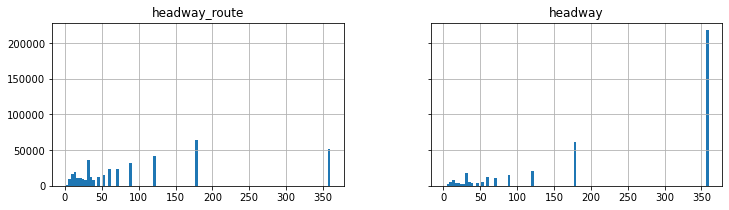

In [13]:
# Route headways seem to make route choice more reliable
(sm.links[['headway_route', 'headway']]/60/2).hist(bins=100, figsize=(12,3), sharey=True)

In [14]:
# Set a maximum headway in order to not confuse the pathfinder
urban_dict = sm.nodes['FID'].map(sm.zones['urbanisation'].to_dict()).to_dict()
for u in [1,2,3]:
    for mode in sm.pt_route_types:
        mask = (sm.links['route_type']==mode)&(sm.links['a'].map(urban_dict)==u)
        sm.links.loc[mask, 'headway'] = np.minimum(
            sm.links.loc[mask, 'headway_route'],
            params['max_headway_urban'+str(int(u))][mode])
#sm.links['headway'] = sm.links['headway_route']

In [15]:
sm.links['headway'] = sm.links['headway'].astype(int)

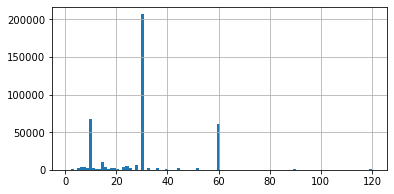

In [16]:
# Waiting time distribution in minutes
if manual: (sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
# Average waiting time
sm.links.groupby('route_type').agg({'headway': 'mean'})/60/2

,headway
route_type,
air,45.000000
bus,29.970167
coach,69.252825
rail_long,32.054820
rail_short,24.044080


In [18]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = params['transfer_penalty']
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict) # in s

In [19]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [20]:
sm.links.sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,headway,route_type_disagg,headway_route,boarding_time,length
index,,,,,,,,,,,,,
bus_56700,bus,"LINESTRING (6.09784 51.06528, 6.09471 51.06228)",b_DEA29_0_61,b_DEA29_0_11,1,bus_10326,120,bus_10326_4,3600,bus,4800,0,398.0


In [21]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

<AxesSubplot:>

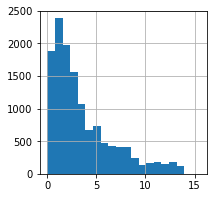

In [22]:
(sm.footpaths['time']/60).hist(bins=20, figsize=(3,3))

### Check zone_to_transit connectors

All zones need connectors

In [23]:
# Add missing connectors
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[set(sm.zones.index) - set(sm.zone_to_transit['a'])],
    sm.nodes.loc[sm.nodes['route_type']=='bus'],
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_transit = sm.zone_to_transit.append(
    ntlegs[set(sm.zone_to_transit.columns).intersection(ntlegs.columns)]
).reset_index(drop=True)

In [24]:
assert set(sm.zones.index) - set(sm.zone_to_transit['a']) == set()

In [25]:
# Add a initial waiting time for PT access legs
sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'time'] += \
    params['access-egress_links']['time_pt']

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [26]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [27]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
#ppf.mode_combinations = [x for x in ppf.mode_combinations
#                         if not ('coach' in x and
#                         ('rail_long' in x or
#                          'rail_short' in x or
#                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'coach', 'rail_long', 'rail_short'},
 {'air', 'bus', 'coach', 'rail_long'},
 {'air', 'bus', 'coach', 'rail_short'},
 {'air', 'bus', 'coach'},
 {'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'coach', 'rail_long', 'rail_short'},
 {'air', 'coach', 'rail_long'},
 {'air', 'coach', 'rail_short'},
 {'air', 'coach'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach', 'rail_long', 'rail_short'},
 {'bus', 'coach', 'rail_long'},
 {'bus', 'coach', 'rail_short'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach', 'rail_long', 'rail_short'},
 {'coach', 'rail_long'},
 {'coach', 'rail_short'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [28]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

The volumes file is not (yet) available


In [ ]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: {'bus', 'air'} :  25%|████████████▎                                    | 8/32 [15:21<52:59, 132.49s/it]

In [ ]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

In [ ]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample()

### Add attributes to LoS table

In [ ]:
# Drop within-cell connections
sm.pt_los = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]
sm.pt_los.shape

In [ ]:
# Add distances (Only path, not access/egress)
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [ ]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
sm.pt_los.columns

In [ ]:
# Substract the waiting time at the first stop
headway_dict = sm.links['headway'].to_dict()
mask = sm.pt_los['link_path'].apply(lambda l: l[0]).map(sm.links['route_type'].to_dict())!='air'
sm.pt_los.loc[mask, 'time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2
sm.pt_los.loc[mask, 'waiting_time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2

In [ ]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

In [ ]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [ ]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [ ]:
sm.pt_los.sample()

In [ ]:
# Make a safety copy before restricting results
if manual: los = sm.pt_los.copy()

In [ ]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [ ]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

In [ ]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

In [ ]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

In [ ]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x))]
sm.pt_los.shape

In [ ]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

In [ ]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<params['clean_los']['max_duration']]
sm.pt_los.shape

In [ ]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

In [ ]:
if manual: sm.pt_los.hist(column='ntransfers', figsize=(4,4))

In [ ]:
# Main mode distribution by transfers
if manual:
    t = sm.pt_los.copy()
    t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                       labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by number of transfers',
        legend=False, labeldistance=None)
    axs[0].legend(loc='lower left')

In [ ]:
# Distribution of mode combinations
if manual:
    t['route_types'] = t['route_types'].apply(tuple)
    t.groupby('route_types').count()['route_type'].plot(kind='bar')

In [ ]:
if manual:
    #t['time'] = t['time'] / 60
    t['bins'] = pd.cut(t['time'], bins=[0,30,60,120,360,5000],
                       labels=["0-30","31-60","61-120","120-360","361+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by trip duration',
        legend=False, labeldistance=None)
    axs[0].legend()

In [ ]:
if manual: t = None

In [ ]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=
                              params['clean_los']['max_transfers']]
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('c')])>2)
                                ))]
sm.pt_los.shape

In [ ]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(
        list(range(params['clean_los']['n_fastest_trips']))).reset_index()
sm.pt_los.shape

In [ ]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') &
                            (sm.pt_los['length']>params['clean_los']['max_dist_bus']))]
sm.pt_los.shape

In [ ]:
# Also drop coach trips for local transport
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                            (sm.pt_los['length']<params['clean_los']['min_dist_coach']))]
sm.pt_los.shape

In [ ]:
# Drop rail short-distance trips above a distance threshold,
# if a long-distance connection is available
sm.pt_los['both'] = sm.pt_los.merge(
    sm.pt_los.groupby(['origin', 'destination'])['route_type'].apply(
        lambda od: 'rail_short' in list(od) and 'rail_long' in list(od)).rename('both'),
    left_on=['origin', 'destination'], right_index=True)['both']
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='rail_short') &
                            (sm.pt_los['both']==True) &
                            (sm.pt_los['length']>params['clean_los']['max_dist_rail_short']))]
sm.pt_los.drop('both', axis=1, inplace=True)
sm.pt_los.shape

In [ ]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

In [ ]:
if manual: sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [ ]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=False, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=False, alpha=.5))

In [ ]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

In [ ]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

In [ ]:
print(len(sm.pt_los))
assert len(sm.pt_los.loc[sm.pt_los.isna().any(axis=1)])==0

## Save model

In [ ]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [ ]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [ ]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [ ]:
sm.pt_los.sample()

In [ ]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'], encoding='utf-8')